In [5]:
import functools

import jax
import jax.numpy as jnp

Text(0, 0.5, 'magn')

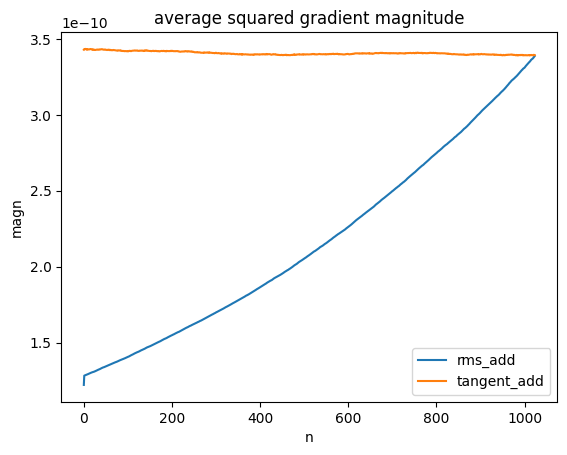

In [55]:
def tangent_add(h, v, eps=1e-9):
	"""
	h: (..., d) current hidden state
	v: (..., d) residual update
	returns h + P_h v  where P_h = I - h hᵀ / ||h||²
	"""
	dot = jnp.sum(h * v, axis=-1, keepdims=True, dtype=jnp.float32)
	norm2 = jnp.sum(h * h, axis=-1, keepdims=True, dtype=jnp.float32)
	# v_tangent = v - (dot / (norm2 + eps)) * h
	# return h + v_tangent.astype(h.dtype)

	return (1 - (dot / (norm2 + eps))).astype(h.dtype)*h + v

def rms_add(h, v, eps=1e-9):
	h = h+v
	var = jnp.mean(jnp.square(h), axis=-1, keepdims=True)
	return h * jax.lax.rsqrt(var + eps)

@jax.jit
@functools.partial(jax.grad, argnums=(1,), has_aux=True)
def fn1(key, v):
	h = jax.random.normal(key, v.shape[1:])
	h, _ = jax.lax.scan(lambda h, x: (rms_add(h, x), None), h, v)

	return jnp.square(h - jax.random.normal(key, v.shape[-1])).mean(), h

@jax.jit
@functools.partial(jax.grad, argnums=(1,), has_aux=True)
def fn2(key, v):
	h = jax.random.normal(key, v.shape[1:])
	h, _ = jax.lax.scan(lambda h, x: (tangent_add(h, x), None), h, v)

	return jnp.square(h - jax.random.normal(key, v.shape[-1])).mean(), h

# gradients for n = 1 … 20
random = jax.random.PRNGKey(0)
v01 = jax.random.normal(random, (1024, 1024, 100))*0.03125
(dv1,), h1 = fn1(random, v01)
magn1 = jnp.square(dv1).mean(axis=(1, 2))

random = jax.random.PRNGKey(0)
v02 = jax.random.normal(random, (1024, 1024, 100))*0.03125
(dv2,), h2 = fn2(random, v02)
magn2 = jnp.square(dv2).mean(axis=(1, 2))

import matplotlib.pyplot as plt

plt.plot(magn1, label='rms_add')
plt.plot(magn2, label='tangent_add')
plt.legend()
plt.title('average squared gradient magnitude')
plt.xlabel('n')
plt.ylabel('magn')

In [56]:
jnp.square(h1).mean()

Array(1., dtype=float32)

In [57]:
jnp.square(h2).mean()

Array(1.9921719, dtype=float32)